<a href="https://www.kaggle.com/code/karan842/pneumonia-detection-transfer-learning-95-acc?scriptVersionId=91935490" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# AI for Medical Diagnoisis:
Computer Vision has a lot of applications in medical diagnosis:
- Dermatology
- Ophthakmology
- Histopathlogy

Perhaps, `X-rays` images are critical for the detection of lung cancer, pneumenia ... 

Steps are: 

- Data pre-processing
- Preprocess images properly for the train, validation and test sets.
- Set-up a pre-trained neural network to make disease predictions on chest X-rays.

# What is Pneumonia?

- Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.

- Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.

![pneumonia](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSPPW6B1QQMf3UDXkwO3RmJl1qLPPIfuDmX2w&usqp=CAU)

# Importing necessary libraries

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

## Loading the data

In [2]:
train_dir = "../input/chest-xray-pneumonia/chest_xray/train"
test_dir = "../input/chest-xray-pneumonia/chest_xray/test"
val_dir = "../input/chest-xray-pneumonia/chest_xray/val"

## Basic Data information.

In [3]:
print("Train set:")
print("-"*60)
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("\nTest set:")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("\nValidation set")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA")
pneumonia_dir = "../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"

Train set:
------------------------------------------------------------
PNEUMONIA=3875
NORMAL=1341

Test set:
------------------------------------------------------------
PNEUMONIA=390
NORMAL=234

Validation set
------------------------------------------------------------
PNEUMONIA=8
NORMAL=8


# X-ray images having PNEUMONIA

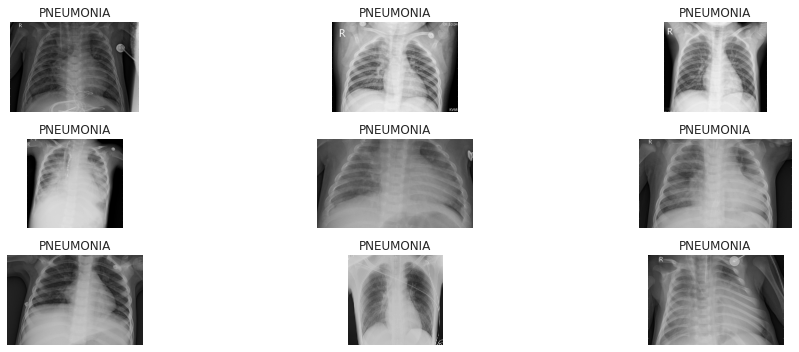

In [4]:
plt.figure(figsize=(15, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.title("PNEUMONIA")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    

plt.tight_layout()

# NORMAL X-ray images

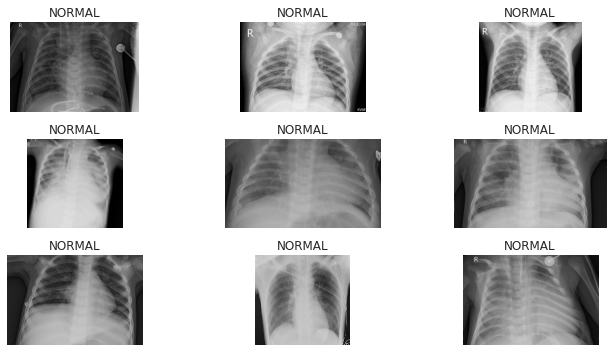

In [5]:
normal = os.listdir("../input/chest-xray-pneumonia/chest_xray/train/NORMAL")
normal_dir = "../input/chest-xray-pneumonia/chest_xray/train/NORMAL"

plt.figure(figsize=(10, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.title("NORMAL")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()


In [6]:
import glob

pneumonia_train = glob.glob(train_dir+"/PNEUMONIA/*.jpeg")
normal_train = glob.glob(train_dir+"/NORMAL/*.jpeg")

- Creating dataframe for counting classes.

In [7]:
data = pd.DataFrame(np.concatenate([[0]*len(normal_train) , [1]*len(pneumonia_train)]),columns=["class"])

Labels are: `0 - NORMAL || 1 - PNEUMONIA`

In [9]:
data.head()

,class
0,0
1,0
2,0
3,0
4,0


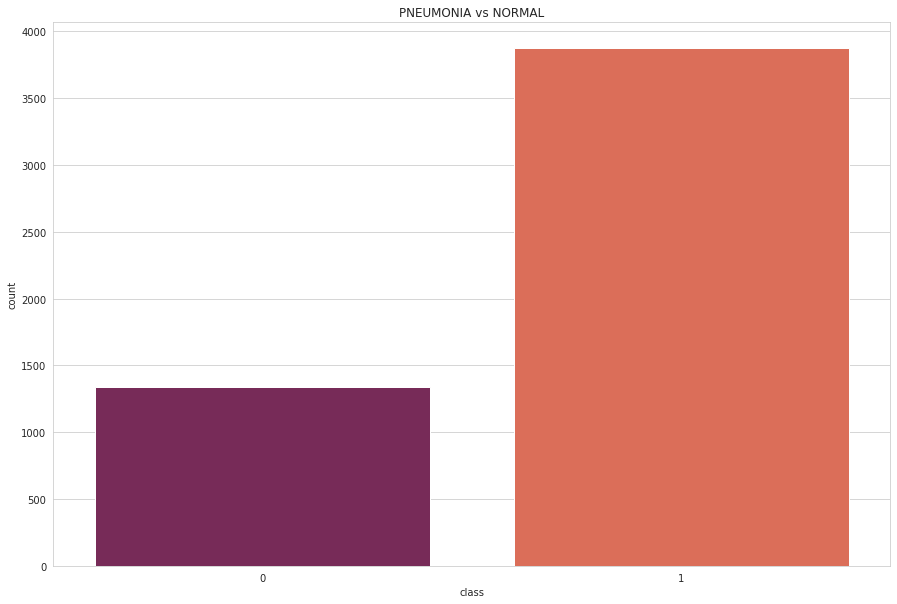

In [10]:
plt.figure(figsize=(15,10))
sns.countplot(data['class'],data=data,palette='rocket')
plt.title('PNEUMONIA vs NORMAL')
plt.show()

### There are more images of PNEUMONIA affected Xrays than NORMAL.

## Data Augmentation
- Using `ImageDataGenerator`, to augment our images so as to create a larger dataset for our model to train on..

In [11]:
img_Datagen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [12]:

train = img_Datagen.flow_from_directory(train_dir,
                                       batch_size=32,
                                       class_mode='binary',
#                                        target_size=(224,224,3))
                                       )

validation = val_Datagen.flow_from_directory(val_dir,
                                              batch_size=2,
                                              class_mode='binary',
#                                               target_size=(224,224,3))
                                            )

test = val_Datagen.flow_from_directory(test_dir,
                                       batch_size=2,
                                       class_mode='binary',
#                                        target_size=(224/,224,3))
                                      )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [13]:
img, label = next(train)

# Defining the model
- Using pre-trainied VGG19 model.
- Freezing all the layers of model of train.
- Using Adam as optimizer and binary_crossentropy as loss function.
- Using callbacks for avoiding overfitting case.
- Using ResNet pre-trained keras model
- Finding the best one among the and performing Fine Tune on it.
- Model evaluations.

In [14]:
vgg_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
#     input_shape = (224,224,3)
)

for layer in vgg_model.layers:
    layer.trainable=False
    
x = vgg_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=vgg_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

2022-04-02 15:24:43.018460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 15:24:43.102275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 15:24:43.102972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 15:24:43.104305: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 1s 0us/step


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [16]:
history = model.fit(train,epochs=30, 
                    validation_data=validation,
                     steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

2022-04-02 15:25:04.747112: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-04-02 15:25:07.216996: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


100/100 [==============================] - 113s 1s/step - loss: 0.4944 - accuracy: 0.7628 - val_loss: 0.5903 - val_accuracy: 0.6875
Epoch 2/30
100/100 [==============================] - 94s 940ms/step - loss: 0.4217 - accuracy: 0.7969 - val_loss: 0.4690 - val_accuracy: 0.8125
Epoch 3/30
100/100 [==============================] - 86s 864ms/step - loss: 0.3961 - accuracy: 0.8184 - val_loss: 0.4667 - val_accuracy: 0.8125
Epoch 4/30
100/100 [==============================] - 83s 831ms/step - loss: 0.3660 - accuracy: 0.8344 - val_loss: 0.4817 - val_accuracy: 0.7500
Epoch 5/30
100/100 [==============================] - 83s 830ms/step - loss: 0.3472 - accuracy: 0.8406 - val_loss: 0.4387 - val_accuracy: 0.8125
Epoch 6/30
100/100 [==============================] - 80s 804ms/step - loss: 0.3290 - accuracy: 0.8519 - val_loss: 0.4101 - val_accuracy: 0.8125
Epoch 7/30
100/100 [==============================] - 82s 818ms/step - loss: 0.3280 - accuracy: 0.8541 - val_loss: 0.4127 - val_accuracy: 0.812

# Evaluating the VGG19

In [17]:
# Evaluating the model on train and test
score = model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

163/163 [==============================] - 132s 812ms/step - loss: 0.2764 - accuracy: 0.8706
Train Loss:  0.2763555943965912
Train Accuracy:  0.8705905079841614


In [18]:
# Test data
score = model.evaluate(test)

print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

312/312 [==============================] - 11s 34ms/step - loss: 0.3667 - accuracy: 0.8446
Test Loss:  0.3666607737541199
Test Accuracy:  0.8445512652397156


Text(0.5, 1.0, 'Accuracy Evolution')

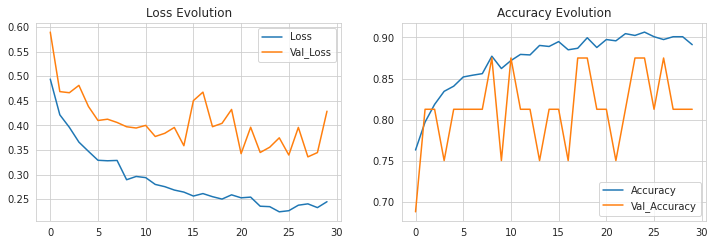

In [19]:
plt.figure(figsize=(12, 8))
plt.title('EVALUATION OF VGG19')

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

### `VGG19` doesn't satisfying us that much specially in test accuracy. Let's see the other keras pre-trained model.

# ResNet50V2

In [22]:
resnet_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    layer.trainable=False
    
x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model2 = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

# to avoid overfitting
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=6)

# Compiling the model
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [23]:
history = model2.fit(train,epochs=30, 
                    validation_data=validation,
                     steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - 86s 825ms/step - loss: 0.3141 - accuracy: 0.8625 - val_loss: 0.1857 - val_accuracy: 0.9375
Epoch 2/30
100/100 [==============================] - 83s 821ms/step - loss: 0.1899 - accuracy: 0.9187 - val_loss: 0.3292 - val_accuracy: 0.8750
Epoch 3/30
100/100 [==============================] - 81s 809ms/step - loss: 0.2073 - accuracy: 0.9137 - val_loss: 0.1851 - val_accuracy: 0.9375
Epoch 4/30
100/100 [==============================] - 82s 817ms/step - loss: 0.1853 - accuracy: 0.9262 - val_loss: 0.2529 - val_accuracy: 0.8750
Epoch 5/30
100/100 [==============================] - 81s 815ms/step - loss: 0.1707 - accuracy: 0.9291 - val_loss: 0.2155 - val_accuracy: 0.8750
Epoch 6/30
100/100 [==============================] - 80s 804ms/step - loss: 0.1574 - accuracy: 0.9372 - val_loss: 0.2429 - val_accuracy: 0.8125
Epoch 7/30
100/100 [==============================] - 82s 817ms/step - loss: 0.1796 - accuracy: 0.9306 - val_loss: 0.1631 - val_ac

In [25]:
# Evaluating the model on train and test
score = model2.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model2.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 132s 808ms/step - loss: 0.1173 - accuracy: 0.9555
Train Loss:  0.11729855090379715
Train Accuracy:  0.9555214643478394
312/312 [==============================] - 8s 26ms/step - loss: 0.1998 - accuracy: 0.9199

Test loss:  0.19975192844867706
Test Accuracy:  0.9198718070983887


Text(0.5, 1.0, 'Accuracy Evolution')

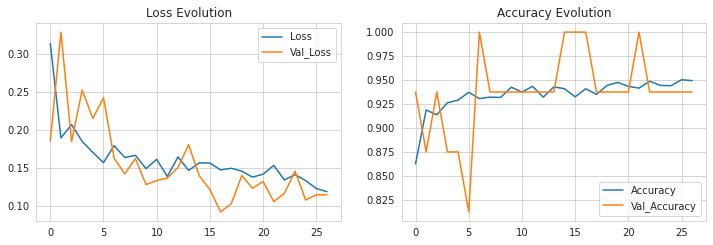

In [26]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

# Observation:
- `ResNet50V2` perofmed well and looks better on the graph than `VGG19`. 

# Fine Tuning
- One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

In [27]:
resnet_model.trainable = True

In [28]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(resnet_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in resnet_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  190


In [29]:
# Compiling the model
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [30]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [31]:
len(model2.trainable_variables)

86

In [33]:
fine_tune_epochs = 10
epochs_on_raw_model = 30

total_epochs =  epochs_on_raw_model + fine_tune_epochs

history_fine =model2.fit(train,epochs=total_epochs, 
                    validation_data=validation,
                    steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/40
100/100 [==============================] - 88s 837ms/step - loss: 0.2950 - accuracy: 0.8969 - val_loss: 0.0938 - val_accuracy: 0.9375
Epoch 2/40
100/100 [==============================] - 82s 824ms/step - loss: 0.1690 - accuracy: 0.9372 - val_loss: 25.1485 - val_accuracy: 0.8125
Epoch 3/40
100/100 [==============================] - 82s 822ms/step - loss: 0.1674 - accuracy: 0.9419 - val_loss: 1.6821 - val_accuracy: 0.6875
Epoch 4/40
100/100 [==============================] - 83s 832ms/step - loss: 0.1563 - accuracy: 0.9431 - val_loss: 0.1472 - val_accuracy: 0.9375
Epoch 5/40
100/100 [==============================] - 83s 828ms/step - loss: 0.1413 - accuracy: 0.9466 - val_loss: 5.4022 - val_accuracy: 0.6250
Epoch 6/40
100/100 [==============================] - 83s 832ms/step - loss: 0.1386 - accuracy: 0.9422 - val_loss: 1.0553 - val_accuracy: 0.6875
Epoch 7/40
100/100 [==============================] - 84s 839ms/step - loss: 0.1482 - accuracy: 0.9425 - val_loss: 1.9636 - val_a

# Evaluating the Fine Tune model

In [35]:
# Evaluating the model on train and test
score = model2.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model2.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 126s 776ms/step - loss: 0.0655 - accuracy: 0.9780
Train Loss:  0.06547978520393372
Train Accuracy:  0.9779524803161621
312/312 [==============================] - 8s 26ms/step - loss: 0.1631 - accuracy: 0.9439

Test loss:  0.16307932138442993
Test Accuracy:  0.9439102411270142


Text(0.5, 1.0, 'Accuracy Evolution')

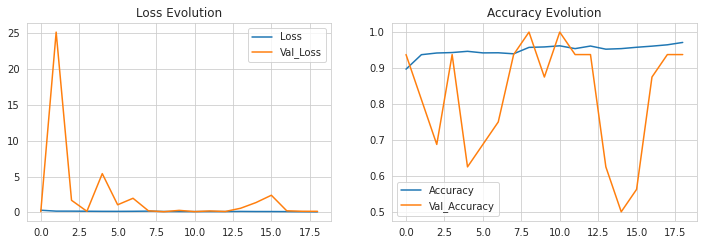

In [42]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history_fine.history['loss'], label='Loss')
plt.plot(history_fine.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history_fine.history['accuracy'], label='Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

- After fine tuning on `ResNet50V2` we got accuracy on test data is `~95%`
- Next step is deployment of `Pneumonia Detection webapp with X-Ray Image`.

### That's it for today. Do upvote this kernel
## Thank You!